In [1]:
# Import essential lib
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
class preproccess_df():
    
    def __init__(
        self):
        
        self.df = _df
    
    def get_df():
        df = pd.read_csv('final_df_europe.csv')
        df = df.set_index('year')
        df = df[(df['country'] == 'France') & (df['sector'] == 'Transportation') & (df['gas'] == 'CO2')]
        df = df.drop(['Unnamed: 0', 'country', 'sector', 'gas'], axis=1)
        df.index = pd.to_datetime(df.index, format='%Y')
        df = df.sort_values(by='year')
        
        return df
    

    def split_df():
        
        df = preproccess_df.get_df()
        train, test = train_test_split(df, test_size = 0.2, shuffle = False)

        return train, test

In [4]:
class models():
    
    def __init__(
        self):
        
        self.df = preproccess_df.get_df()
        self.train = preproccess_df.split_df()[0]
        self.test = preproccess_df.split_df()[1]

    def best_order_arima(self):
        # Get best value for order
        p_values = range(0, 6)
        d_values = range(0, 4)
        q_values = range(0, 6)
        
        best_score, best_params = float("inf"), None
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    warnings.filterwarnings("ignore")
                    model = sm.tsa.arima.ARIMA(self.train, order=order).fit()
                    predictions = model.predict(start=len(self.train), end=len(self.train) + len(self.test)-1)
                    error = mean_absolute_error(self.test, predictions)
                    if error < best_score:
                            best_params = order
                            best_score = error
   
        return best_params, best_score
    
    def predict_arima_model(self):
        
        best_params = self.best_order_arima()[0]
        arima = sm.tsa.arima.ARIMA(self.train, order=best_params)
        arima_fitted = arima.fit()
        arima_pred = arima_fitted.get_forecast(steps=6).summary_frame() 
        
        arima = sm.tsa.arima.ARIMA(self.df, order=best_params)
        arima_fitted = arima.fit()

        arima_forecasts = arima_fitted.get_forecast(steps=10).summary_frame() 

        return arima_pred, arima_forecasts
    
    def predict_lin_reg(self):
        
        df_lin_reg = self.df
        df_lin_reg.index = pd.to_datetime(df_lin_reg.index, format='%Y').strftime("%Y")
        train, test = train_test_split(df_lin_reg, test_size = 0.2, shuffle = False)

        X_train_lr = pd.DataFrame(train.index)
        y_train_lr = train
        X_test_lr = pd.DataFrame(test.index)
        y_test_lr = test

        lr = LinearRegression()

        lr.fit(X_train_lr,y_train_lr)
        y_pred_lr = lr.predict(X_test_lr)
        
        
        return y_pred_lr, X_test_lr


In [7]:
class visualisation():
    
    def __init__(
        self):
        
        model = models()
        
        self.df = preproccess_df.get_df()
        self.train = preproccess_df.split_df()[0]
        self.test = preproccess_df.split_df()[1]
        self.arima = model.predict_arima_model()
        self.lin_reg = model.predict_lin_reg()
    
    def arima_model(self):
        
        arima_pred, arima_forecasts = self.arima
        
        fig, ax = plt.subplots(figsize = (15,5))

        plt.plot(self.df, label = 'real emissions')

        arima_pred['mean'].plot(ax = ax, style = 'k--', label = 'predictions') 

        arima_forecasts['mean'].plot(ax = ax, style = '--', color = 'red', label = 'forecasts') 

        ax.fill_between(arima_pred.index, arima_pred['mean_ci_lower'], arima_pred['mean_ci_upper'], color='k', alpha=0.1)

        ax.fill_between(arima_forecasts.index, arima_forecasts['mean_ci_lower'], arima_forecasts['mean_ci_upper'], color='k', alpha=0.1)

        plt.ylabel("Emissions in MtCO₂e")
        plt.legend(loc = 'upper left');
        
        
        
    def lin_reg_model(self):
        
        y_pred_lr, X_test_lr = self.lin_reg
        df_lin_reg = self.df
        df_lin_reg.index = pd.to_datetime(df_lin_reg.index, format='%Y').strftime("%Y")
        
        plt.figure(figsize = (10,4))
        plt.plot(df_lin_reg.index, df_lin_reg, label ='reality')
        plt.plot(X_test_lr.year, y_pred_lr, label ='prediction')
        plt.title('Transportation CO2 emissions predictions with Linear Regression')
        plt.ylabel("Emissions in MtCO₂e")
        plt.xticks(rotation=45)
        plt.legend();

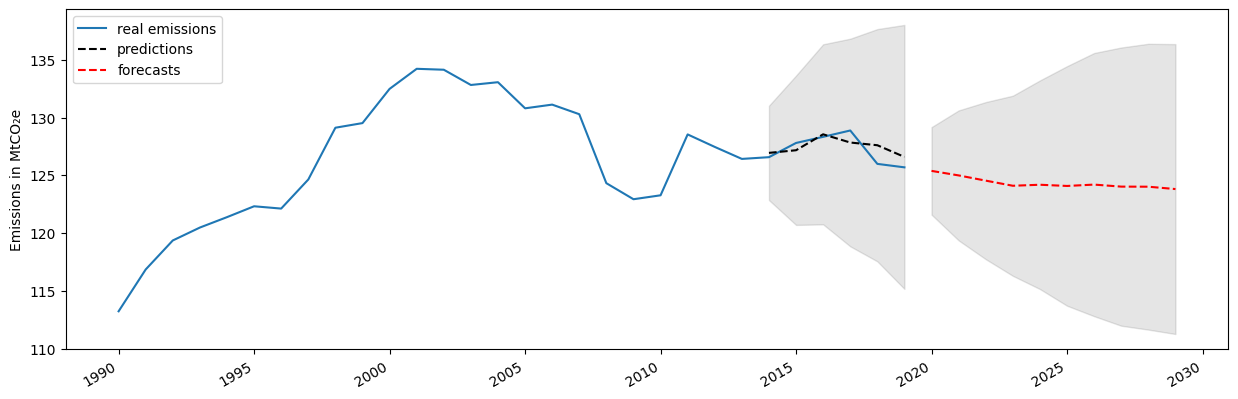

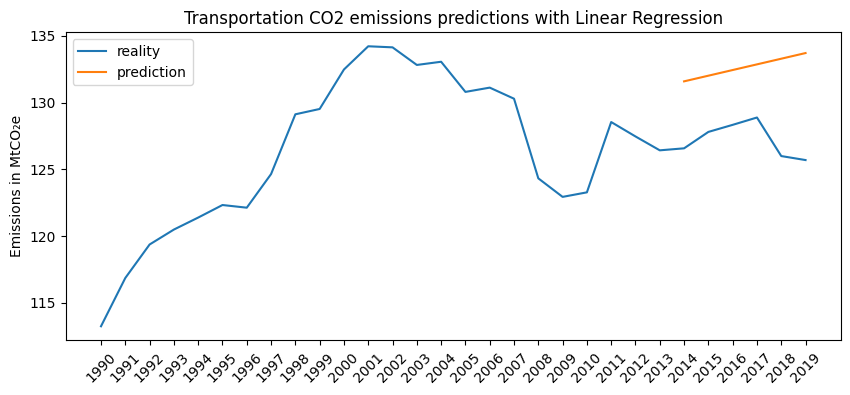

In [8]:
visualisation = visualisation()  
def vis_models(visualisation):
    arima = visualisation.arima_model()
    lin_reg = visualisation.lin_reg_model()
    model_type = [arima, lin_reg]
    for model in model_type:
        model
vis_models(visualisation)

In [61]:
class calculate_scores(y_true,y_pred):
    
    def __init__(
    self):
        self.df = preproccess_df.get_df()
        self.train = preproccess_df.split_df()[0]
        self.test = preproccess_df.split_df()[1]
        
        
    def print_scores(y_true,y_pred):
        print("MAE:", mean_absolute_error(y_true,y_pred))
        print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
        print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))
        print("r2", r2_score(y_true,y_pred))